# สร้างแบบจำลอง ML Regression Model ด้วย Ensemble Boosting algorithms
โค้ดจาก Kaggle https://www.kaggle.com/code/venkatkrishnan/regression-model-on-multicollinary-dataset#Regression-Model-on-Multicollinary-Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import KFold, train_test_split

from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

# Boosting algorithm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

## 1. Reading and Cleansing data

In [2]:
df = pd.read_csv('./00Results/df_org_dbz_rain_test200km_full_features.csv')
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## 2. Exploratory Data Analysis

In [3]:
df.describe()

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,rain_truth
count,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000
mean,28.312452,28.417807,28.421282,28.115109,2.170921
std,7.981244,7.883439,7.810217,7.769884,4.443954
min,1.553552,1.187277,-1.999605,-4.499764,0.100000
25%,22.931310,23.175378,23.352370,23.290597,0.200000
50%,27.599644,27.829594,27.965809,27.917465,0.600000
75%,33.327730,33.424530,33.544266,33.251520,2.000000
max,57.279980,57.279980,57.279976,57.243618,72.000000


<Figure size 1200x600 with 0 Axes>

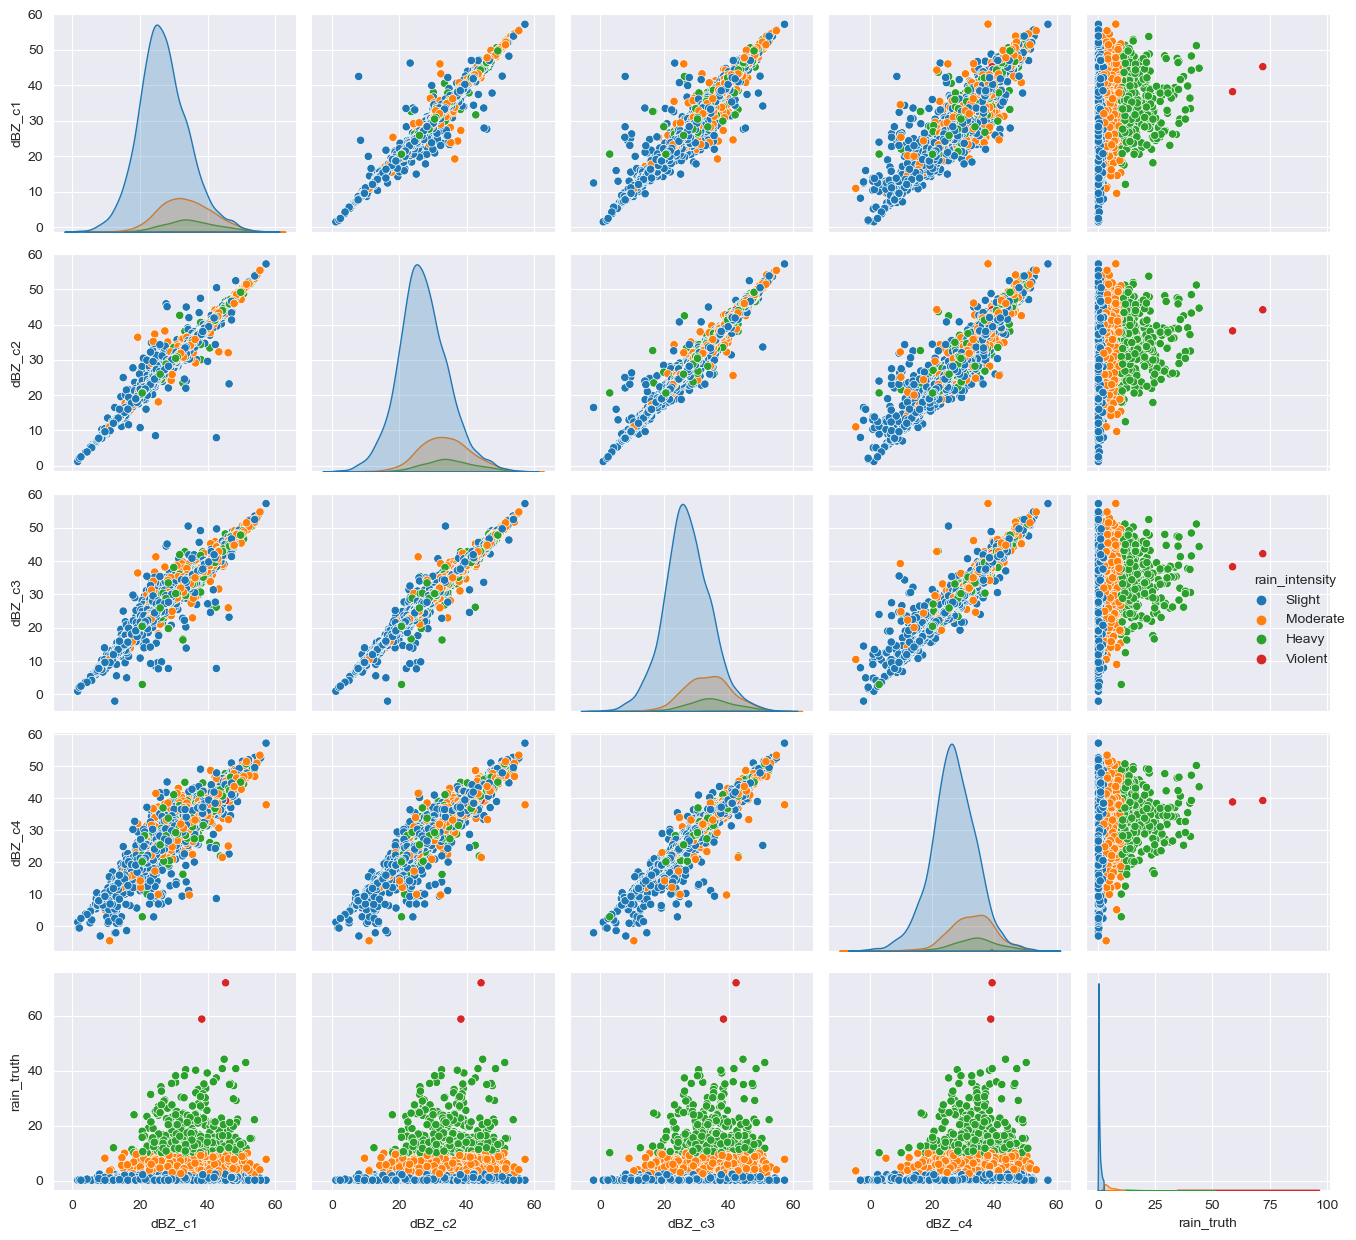

In [4]:
plt.figure(figsize=(12,6))
cols_to_plot = ['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'rain_truth','rain_intensity']
sns.set_style({'font.family':'Tahoma'})
sns.set_style('darkgrid')
sns.pairplot(df[cols_to_plot], diag_kind='auto', hue='rain_intensity', hue_order=['Slight', 'Moderate', 'Heavy', 'Violent'])
plt.tight_layout()
plt.show()

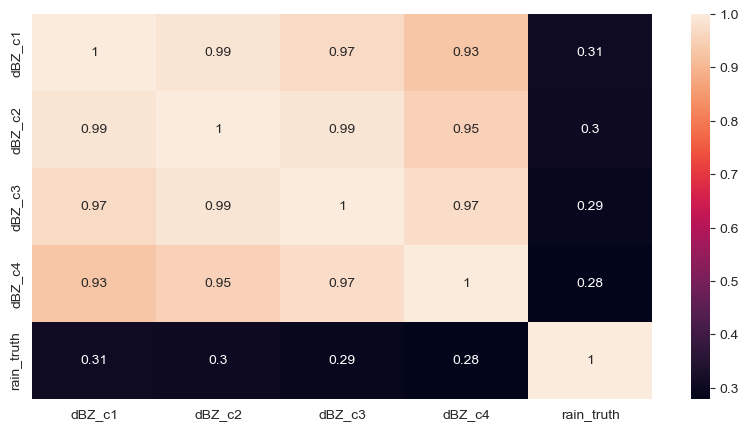

In [5]:
# Compute correlation between the variables
cols_to_plot = ['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'rain_truth','rain_intensity']
corr = df[cols_to_plot].corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)
plt.show()

In [6]:
#df=df[['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'rain_truth']]
df=df[['dBZ_c1', 'dBZ_c2', 'rain_truth']]
df

,dBZ_c1,dBZ_c2,rain_truth
0,18.245508,17.964867,10.8
1,25.722824,25.153559,0.4
2,44.015987,40.230587,0.2
3,35.751709,35.933075,3.0
4,33.936577,33.623489,5.6
...,...,...,...
6718,30.518427,30.446016,38.2
6719,27.239044,27.240294,0.2
6720,28.382376,28.203165,0.2
6721,25.915712,25.959574,24.8


In [7]:
import numpy as np
from scipy.stats import pearsonr

# Assuming df is your DataFrame
for i in range(df.shape[1]-1):
    feature = df.columns[i]
    X = df[feature].values
    y = pd.to_numeric(df['rain_truth'], errors='coerce').dropna()

    # Calculate the correlation
    r = np.round(pearsonr(X, y), 2)
    print(f"Feature rain_truth vs {feature}: r-value : {r}")

Feature rain_truth vs dBZ_c1: r-value : [0.31 0.  ]
Feature rain_truth vs dBZ_c2: r-value : [0.3 0. ]


## 3. Feature Engineering

In [8]:
# Step 2: Defining the columns and reading the DataFrame 
TargetVariable=['rain_truth']
#Predictors=['dBZ_c1'] # แบบจำลองดี
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4', 'dBZ_p1', 'dBZ_p2', 'dBZ_p3', 'dBZ_p4', 
#            'rr_MP_c1', 'rr_MP_c2', 'rr_MP_c3', 'rr_MP_c4', 'rr_MP_p1', 'rr_MP_p2', 'rr_MP_p3', 'rr_MP_p4', 
#            'rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4', 'rr_RF_p1', 'rr_RF_p2', 'rr_RF_p3','rr_RF_p4', 
#            'rr_SC_c1', 'rr_SC_c2', 'rr_SC_c3', 'rr_SC_c4', 'rr_SC_p1', 'rr_SC_p2', 'rr_SC_p3', 'rr_SC_p4'] # แบบจำลองไม่ดี 

#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_p1', 'dBZ_p2',  
#            'rr_MP_c1', 'rr_MP_c2', 'rr_MP_p1', 'rr_MP_p2',
#            'rr_RF_c1', 'rr_RF_c2', 'rr_RF_p1', 'rr_RF_p2',
#            'rr_SC_c1', 'rr_SC_c2', 'rr_SC_p1', 'rr_SC_p2']  # แบบจำลองไม่ดี 
#Predictors=['dBZ_c1', 'dBZ_c2'] 
Predictors=['dBZ_c1'] 

#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4'] # แบบจำลองดี
#Predictors=['dBZ_p1', 'dBZ_p2', 'dBZ_p3', 'dBZ_p4'] # แบบจำลองไม่ดีน้อยกว่า cappi ล้วน
#Predictors=['dBZ_c1', 'dBZ_c2','dBZ_p1', 'dBZ_p2'] # แบบจำลองค่อนข้างดี 
#Predictors=['rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4', 'rr_RF_p1', 'rr_RF_p2', 'rr_RF_p3','rr_RF_p4'] # แบบจำลองไม่ดี 
#Predictors=['dBZ_c1', 'dBZ_p1'] 

# Step 3: Seperating the data into features and labels
X=df[Predictors].values
y=df[TargetVariable].values

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

### Feature Selection using RandomForest Regressor

In [9]:
# Random forest regressor model to fit the split data
rnf = RandomForestRegressor(n_estimators=300)

rnf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [10]:
y_preds = rnf.predict(X_valid)

print("RMSE : {:.3f} ".format(mean_squared_error(y_valid, y_preds, squared=False)))
# print("RMSLE : {np.sqrt(mean_squared_log_error(y_valid, y_preds))}")

RMSE : 5.167 


In [11]:
rnf.feature_importances_

array([1.])

### Feature Scaling

In [12]:
# StandardScaler to scale the variable values
scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_valid)

X_scaled_df = pd.DataFrame(X_scaled)

In [13]:
X_scaled_df.head()

,0
0,-1.261419
1,-0.324488
2,1.967701
3,0.932162
4,0.704720


## 4.Model Building

In [14]:
lgb_params={
    'learning_rate': 0.1,
    'objective':'regression',
    'importance_type':'split',
    'metric':'rmse',
    'num_leaves': 31,
    "random_state":42,
    'max_depth': 8,
    "bagging_seed" : 42,
    "bagging_frequency" : 5,
    "reg_alpha":0.0,
    "reg_lambda":0.0,
    'min_child_samples': 20,
    'min_child_weight':1
}

xgb_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'max_depth': 8,
    'min_child_weight': 1
}

In [15]:
# Boosting algorithms

lgbm = LGBMRegressor(**lgb_params, n_estimators=900)

xgb = XGBRegressor(**xgb_params, n_estimators=700)

In [16]:
y = pd.DataFrame(y)
y

,0
0,10.8
1,0.4
2,0.2
3,3.0
4,5.6
...,...
6718,38.2
6719,0.2
6720,0.2
6721,24.8


In [17]:
K = 5
kfolds = KFold(n_splits=K, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(kfolds.split(X_scaled_df)):
    
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    X_train, X_valid = X_scaled_df.iloc[train_idx, :], X_scaled_df.iloc[test_idx, :]
    
    print( "\nFold ", i)
    print("-"* 20 + "LGBM Regression" + "-"* 20)
    lgbm.fit(X_train, y_train, 
             eval_metric='rmse',
             eval_set=[(X_valid,  y_valid)],
            early_stopping_rounds=20,
            verbose=10)
    
    print("-"* 20 + "XGB Regression" + "-"* 20)
    xgb.fit(X_train, y_train, 
             eval_metric='rmse',
             eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20,
            verbose=10)


Fold  0
--------------------LGBM Regression--------------------
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[10]	valid_0's rmse: 4.41384
[20]	valid_0's rmse: 4.40491
[30]	valid_0's rmse: 4.41442
--------------------XGB Regression--------------------
[0]	validation_0-rmse:4.77725
[10]	validation_0-rmse:4.46617
[20]	validation_0-rmse:4.46067
[30]	validation_0-rmse:4.47574
[33]	validation_0-rmse:4.48879

Fold  1
--------------------LGBM Regression--------------------
[10]	valid_0's rmse: 4.84961
[20]	valid_0's rmse: 4.83025
[30]	valid_0's rmse: 4.83213
[40]	valid_0's rmse: 4.83641
--------------------XGB Regression--------------------
[0]	validation_0-rmse:5.26830
[10]	validation_0-rmse:4.93762
[20]	validation_0-rmse:4.94143
[30]	validation_0-rmse:4.97644
[31]	validation_0-rmse:4.97740

Fold  2
--------------------LGBM Regression--------------------
[10]	valid_0's rmse: 4.17207
[20]	valid_0's rmse: 4.15556
[30]	valid_0's rmse: 4.15587
[40]	valid_0's rmse: 4.16017
----------

### Predicting Test Data

In [18]:
X_test_df = pd.DataFrame(X_test_scaled)

# Invoking model predict method
lgb_preds = lgbm.predict(X_test_df)
xgb_preds = xgb.predict(X_test_df)

### Weighted Average Ensemble

In [19]:
boost_1, boost_2 = 0.3, 0.7 

preds_1 = boost_1 * lgb_preds
preds_2 = boost_2 * xgb_preds

predictions = preds_1 + preds_2

In [20]:
predictions.shape

(1345,)

In [21]:
y_valid.to_numpy().flatten().shape

(1344,)

In [22]:
predictions[:5]

array([6.10900506, 0.78753939, 0.8739883 , 1.51274619, 1.56333421])

In [23]:
y_valid.head

<bound method NDFrame.head of          0
3      3.0
4      5.6
5      0.2
9      8.0
16     0.2
...    ...
6698   0.6
6700   6.4
6707   2.2
6709   4.0
6713  10.8

[1344 rows x 1 columns]>

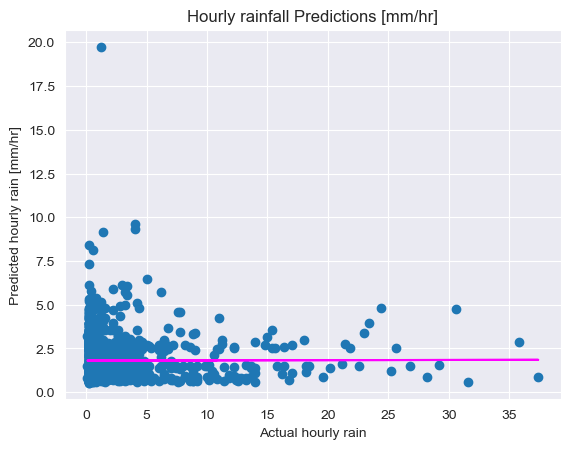

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(y_valid, predictions[0:y_valid.shape[0]])
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_valid.to_numpy().flatten(), predictions[0:y_valid.shape[0]], 1)
p = np.poly1d(z)
plt.plot(y_valid,p(y_valid), color='magenta')
plt.show()

### การวัดประสิทธิภาพแบบจำลองด้วย metric

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_valid.to_numpy().flatten(), predictions[0:y_valid.shape[0]])
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_valid, predictions[0:y_valid.shape[0]])
print("R2:", r2)

MSE: 18.64172417115828
RMSE: 4.317606301083771
R2: -0.09578520122363265


# ผล
ยังไม่เวิร์ค